In [ ]:
!pip install -q ultralytics==8.0.181

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.1/617.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install pytorchsummary

In [ ]:
import cv2
import numpy as np
#from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt

from torchvision import utils
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/ouput' '/content'

In [ ]:
!cp -r '/content/drive/MyDrive/attention_vgg' '/content'
!cp '/content/drive/MyDrive/ouput/data (1).zip' '/content'
!unzip -q '/content/data (1).zip'

In [ ]:

!gdown https://drive.google.com/u/0/uc?id=1peGv96yVDoFSKQvGT0NY5MO1ZyZruCKH&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1peGv96yVDoFSKQvGT0NY5MO1ZyZruCKH
To: /content/data (1).zip
100% 59.3M/59.3M [00:00<00:00, 97.8MB/s]


In [ ]:
!unzip -q '/content/data (1).zip'

In [ ]:
path = '/content/data'
#-------------load label and name of dataset-----------
labels = []
list_name = []
with open(path + '/Label.txt', "r") as f:
    for line in f:
      #print(line)
      if len(line) > 1:
        name, label = line.split('\t')
        list_name.append(name)
        labels.append(label.split(','))

labels = np.array(labels, dtype=int)


In [ ]:
gender_labels = labels[:, 0].reshape(-1, 1)

In [ ]:
gender_labels.shape

(19000, 1)

# visualize data

In [ ]:
gender_labels = []
age_labels = []
count_gender = [0] * 2
count_age = [0] * 5
for l in labels:
  count_gender[l[0]] += 1
  ix = np.argmax(l[1:])
  count_age[ix] += 1

In [ ]:
count

array([[1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0]])

<BarContainer object of 2 artists>

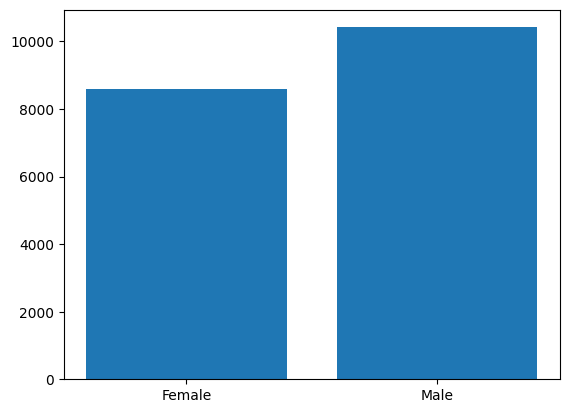

In [ ]:
import matplotlib.pyplot as plt

plt.bar(x = ['Female', 'Male'], height = count_gender)

<BarContainer object of 5 artists>

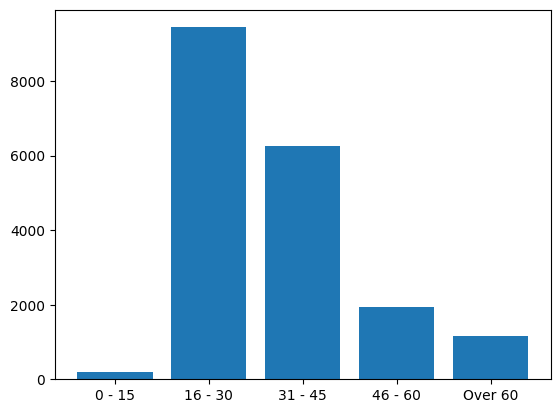

In [ ]:
plt.bar(x = ['0 - 15', '16 - 30', '31 - 45', '46 - 60', 'Over 60'], height = count_age)

# Load data

In [ ]:
labels_train, labels_test, list_name_train, list_name_test = train_test_split(labels, list_name, test_size = 0.1, shuffle = True, random_state=3)

In [ ]:
labels_train, labels_test, list_name_train, list_name_test = train_test_split(gender_labels, list_name, test_size = 0.1, shuffle = True, random_state=3)

In [ ]:
#Dataset
from attention_vgg.Dataset import *

training_set = Dataset(list_name_train, labels_train, path)
training_generator = torch.utils.data.DataLoader(training_set, batch_size = 64)

In [ ]:
#Dataset
from Dataset import *

training_set = Dataset(list_name_train, labels_train, path)
training_generator = torch.utils.data.DataLoader(training_set, batch_size = 64)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


# Load model

In [ ]:
import sys
sys.path.append('/content/attention_vgg/custom')
from ReModel import *
sys.path.append('/content')

In [ ]:
#from attention_vgg import
#from attention_vgg.AttVGG import AttnVGG
from AttVGG2 import AttnVGG


In [ ]:
from attention_vgg.MNet import *


In [ ]:
from attention_vgg.Hydraplus import *

In [ ]:
from GoogleNet import *

In [ ]:
#resnet
import torchvision.models as models
import torch.nn as nn

fc = nn.Sequential(
    nn.Linear(2048, 6),
    nn.Sigmoid()
)
model = models.resnet50(pretrained=True)

model.fc = fc

In [ ]:
#normal cnn
import torchvision.models as models
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 64, 3, 1, padding = 'same'),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, padding = 'same'),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, 3, 1, padding = 'same'),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, 3, 1, padding = 'same'),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 1024, 3, 1, padding = 'same'),
    nn.AvgPool2d((14, 7), 1),
    nn.Flatten(),
    nn.Linear(1024, 6),
    nn.Sigmoid()
)

In [ ]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#model = Model(224, 112)
#model = resnet50_cbam(pretrained=False, num_classes=6)
model = AttnVGG(num_classes = 6, normalize_attn=True)

#model = GoogLeNet
model = model.cuda()

#criterion = FocalLoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from pytorchsummary import summary
summary((3, 224, 112) ,model)

In [ ]:
def evaluate(y_pred, y_true):
  result = [False] * len(y_pred)
  n = len(y_pred[0])
  for i in range(len(y_pred)):
    temp = [0] * n
    temp[0] = 1 if y_pred[i][0] > 0.5 else 0
    if n > 1:
      ix = np.argmax(y_pred[i][1:])
      temp[ix + 1] = 1
    if (temp == y_true[i]).all():
      result[i] = True

  return result

In [ ]:
import time

start_time = time.time()

epochs = 3

train_losses = []
train_auc = []

running_loss = 0
loss_per_epochs = [0.0] * epochs
model.train()

for i in range(epochs):

  result_epoch = []
  # Run the training batches
  for b, (X_train, y_train) in tqdm(enumerate(training_generator), total=len(training_generator)):

      optimizer.zero_grad()

      b += 1
      y_pred, _, _ = model(X_train.cuda())
      #y_pred = model(X_train.cuda())

      #print(y_pred)

      loss = criterion(y_pred.type(torch.FloatTensor), y_train.type(torch.FloatTensor))

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      loss_per_epochs[i] += loss.item()

      r = evaluate(y_pred.cpu().detach().numpy(), y_train.detach().cpu().numpy())
      result_epoch.extend(r)

      if b % 50 == 0:
          n = len(result_epoch)
          t = sum(result_epoch)
          print(f"Loss: {running_loss / 50} Accuracy: {t / n}", )
          running_loss = 0
  train_auc.append(sum(result_epoch) / len(result_epoch))


print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed

 19%|█▊        | 50/268 [00:30<02:14,  1.62it/s]

Loss: 0.5702329802513123 Accuracy: 0.6878125


 37%|███▋      | 100/268 [01:01<01:42,  1.64it/s]

Loss: 0.3504496872425079 Accuracy: 0.7675


 56%|█████▌    | 150/268 [01:31<01:11,  1.64it/s]

Loss: 0.28750588119029996 Accuracy: 0.8040625


 75%|███████▍  | 200/268 [02:02<00:41,  1.63it/s]

Loss: 0.2404162847995758 Accuracy: 0.82890625


 93%|█████████▎| 250/268 [02:33<00:10,  1.64it/s]

Loss: 0.22710475623607634 Accuracy: 0.8445625


 19%|█▊        | 50/268 [00:30<02:12,  1.64it/s]

Loss: 0.27844942912459375 Accuracy: 0.920625


 37%|███▋      | 100/268 [01:01<01:43,  1.62it/s]

Loss: 0.12627908922731876 Accuracy: 0.93609375


 56%|█████▌    | 150/268 [01:32<01:11,  1.64it/s]

Loss: 0.08928061783313751 Accuracy: 0.946875


 75%|███████▍  | 200/268 [02:03<00:42,  1.59it/s]

Loss: 0.05519047394394874 Accuracy: 0.956484375


 93%|█████████▎| 250/268 [02:34<00:10,  1.64it/s]

Loss: 0.061577444337308405 Accuracy: 0.961125


 19%|█▊        | 50/268 [00:30<02:12,  1.65it/s]

Loss: 0.07046744730323554 Accuracy: 0.985625


 37%|███▋      | 100/268 [01:01<01:45,  1.60it/s]

Loss: 0.03584756894037128 Accuracy: 0.98625


 56%|█████▌    | 150/268 [01:32<01:12,  1.63it/s]

Loss: 0.03431362570263445 Accuracy: 0.9866666666666667


 75%|███████▍  | 200/268 [02:03<00:41,  1.64it/s]

Loss: 0.027739386204630137 Accuracy: 0.987734375


 93%|█████████▎| 250/268 [02:33<00:11,  1.62it/s]

Loss: 0.025756381545215846 Accuracy: 0.989125


100%|██████████| 268/268 [02:44<00:00,  1.63it/s]


Duration: 493 seconds


In [ ]:
sum([True, False, True, True])

3

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_auc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Acc"])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_per_epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

In [ ]:
#model = torch.jit.load('/content/attention_vgg/attv1/NewAttVGG.pt')
model = torch.jit.load('/content/attention_vgg/attv2/NewAttVGGV2_1.pt')

In [ ]:
testing_set = Dataset(list_name_test, labels_test, path)
testing_generator = torch.utils.data.DataLoader(testing_set, batch_size = 1)
train_preds = []
y_test = []
results = []
model.eval()
# Run the training batches
for b, (X_train, y_train) in tqdm(enumerate(testing_generator), total=len(testing_generator)):
    #print(X_train.shape, y_train)
    b += 1
    y_pred, _, _ = model(X_train.cuda() )
    #y_pred = model(X_train.cuda())

    res = [0] * 6
    y_pred = y_pred.cpu().detach().numpy().flatten()
    #print(y_pred)
    if y_pred[0] > 0.5:
      res[0] = 1
    ix = np.argmax(y_pred[1:], axis=0)
    res[ix + 1] = 1

    results.append(res)
    y_test.append(y_train.cpu().numpy().flatten())
    #print(res)



100%|██████████| 1900/1900 [00:11<00:00, 159.65it/s]


In [ ]:
y_test = np.array(y_test, dtype = int)
results = np.array(results, dtype = int)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
matrix = multilabel_confusion_matrix(y_test, results)
acc =  accuracy_score(y_test, results)
report = classification_report(y_test, results, zero_division=1)

print(report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.89       861
           1       0.94      0.86      0.90      1039

    accuracy                           0.89      1900
   macro avg       0.89      0.90      0.89      1900
weighted avg       0.90      0.89      0.89      1900



In [ ]:
y_test[:, 1:] == results[:, 1:]

array([[ True,  True,  True,  True,  True],
       [ True,  True, False,  True, False],
       [ True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True, False, False,  True,  True]])

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_recall_fscore_support

acc_gender = accuracy_score(y_test[:, 0], results[:, 0])
acc_age = accuracy_score(y_test[:, 1:], results[:, 1:])

matrix = multilabel_confusion_matrix(y_test, results)

#age_matrix = confusion_matrix(y_test[:, 1:], results[:, 1:])
#gender_matrix = confusion_matrix(y_test[:, 0], results[:, 0])

cr_age = classification_report(y_test[:, 1:], results[:, 1:])
cr_gen = classification_report(y_test[:, 0], results[:, 0])

prf_age = precision_recall_fscore_support(y_test[:, 1:], results[:, 1:], average='micro')
prf_gen = precision_recall_fscore_support(y_test[:, 0], results[:, 0], average='micro')

In [ ]:
acc_gender, acc_age

(0.8926315789473684, 0.8121052631578948)

In [ ]:
print(prf_gen)
print(prf_age)

(0.8926315789473684, 0.8926315789473684, 0.8926315789473683, None)
(0.8121052631578948, 0.8142480211081794, 0.813175230566535, None)


In [ ]:
print(cr_gen)
print(cr_age)

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       861
           1       0.88      0.92      0.90      1039

    accuracy                           0.89      1900
   macro avg       0.89      0.89      0.89      1900
weighted avg       0.89      0.89      0.89      1900

              precision    recall  f1-score   support

           0       0.88      0.50      0.64        14
           1       0.81      0.90      0.85       920
           2       0.80      0.71      0.76       665
           3       0.80      0.75      0.77       204
           4       0.98      0.88      0.93        92

   micro avg       0.81      0.81      0.81      1895
   macro avg       0.85      0.75      0.79      1895
weighted avg       0.81      0.81      0.81      1895
 samples avg       0.81      0.81      0.81      1895



In [ ]:
matrix

array([[[ 575,  286],
        [ 303,  736]],

       [[1886,    0],
        [  10,    4]],

       [[ 706,  274],
        [ 286,  634]],

       [[ 782,  453],
        [ 230,  435]],

       [[1684,   12],
        [ 196,    8]],

       [[1769,   39],
        [  51,   41]]])

In [ ]:
acc

0.9521052631578948

In [ ]:
testing_generator.dataset[1][0].numpy().shape

#plt.imshow(img)

(3, 224, 112)

In [ ]:
def unnormalize(tensor, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    for i in range(tensor.shape[0]):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor


In [ ]:
model = torch.jit.load('/content/attention_vgg/attv1/vgg_attention.pt')

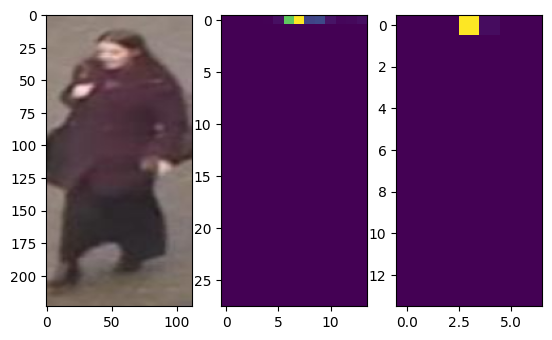

In [ ]:
img = unnormalize(training_generator.dataset[5][0]).permute(1, 2, 0).numpy()
input = torch.unsqueeze(training_generator.dataset[1][0].cuda(), 0)
#input = training_generator.dataset[1][0].cuda(), 0
pred,a1, a2 = model(input)
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(a1[0].permute(1, 2, 0).cpu().detach().numpy())
plt.subplot(1, 3, 3)
plt.imshow(a2[0].permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
a1[0]

In [ ]:
training_generator.dataset[1][0].shape

torch.Size([3, 224, 112])

In [ ]:
import matplotlib.pyplot as plt
display_labels=['age, 0-15', '16-30', '31-45', '46-60', 'Over60']
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, )
disp.plot()
plt.show()

In [ ]:
len(train_targets)

3641

In [ ]:
filename = 'cnn.pt'
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(filename) # Save
# model = torch.jit.load('model_scripted.pt')
# model.eval()
save_path = '/content/model/' + filename

In [ ]:
torch.save(model, '/content/NewAttVGG_not_jit.pt')

In [ ]:
!cp 'cnn.pt' '/content/drive/MyDrive/attention_vgg'

In [ ]:
torch.save(model.state_dict(), 'NewAttVGG_weightsV2_1_epochs10.pth')

In [ ]:
!cp '/content/NewAttVGG_weightsV2_1_epochs10.pth' '/content/drive/MyDrive/attention_vgg'